# Exercise 3: Optimization of Lennard-Jones clusters
**SOLUTION**: adopted from: P. Mlkvik, X. C. Hao
Submission deadline: Sunday, 19. March 18h

## 0. Introduction to the problem
The **Lennard-Jones potential** is a pairwise potential describing intermolecular interactions according to an empirical formulation. For a two-atom system it has the following structure:
\begin{equation}
        V_{LJ} (R) = 4 \varepsilon \left[ \left( \frac{\sigma}{R}\right)^{12} - \left( \frac{\sigma}{R}\right)^{6}\right],
\end{equation}

where $R$ is the interatomic distance, $\varepsilon$ is the so-called **dispersion energy**, and $\sigma$ and is the size of the particle.

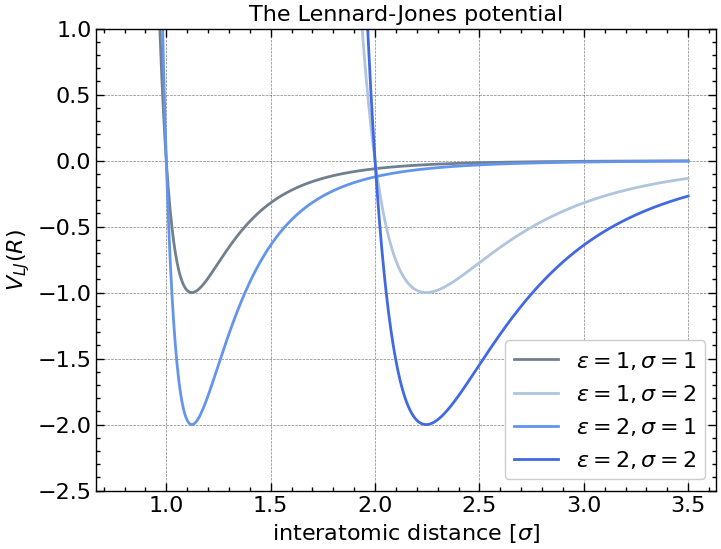

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

plt.title('The Lennard-Jones potential')
R = np.linspace(0.8,3.5,1000)
y11 = 4*(1/R**12-1/R**6)
y12 = 4*((2/R)**12-(2/R)**6)
y21 = 8*(1/R**12-1/R**6)
y22 = 8*((2/R)**12-(2/R)**6)
plt.plot(R,y11,label='$\epsilon=1, \sigma=1$', color='slategrey')
plt.plot(R,y12,label='$\epsilon=1, \sigma=2$', color='lightsteelblue')
plt.plot(R,y21,label='$\epsilon=2, \sigma=1$', color='cornflowerblue')
plt.plot(R,y22,label='$\epsilon=2, \sigma=2$', color='royalblue')
plt.ylim(bottom=-2.5,top=1)
plt.xlabel('interatomic distance [$\sigma$]')
plt.ylabel('$V_{LJ}(R)$')
plt.legend()
plt.show()

There are two terms in the Lennard-Jones potential: the short-range and the long-range. In the short-range regime, the electron densities tend to overlap, giving rise to strong repulsive forces that grow rapidly when distances are shortened. (pauli exclusion principle)

At the same time, as atoms are brought closer the screening effect of the electronic cloud is reduced and cannot compensate for nuclear repulsion.
The short-range term takes into account both of these effects, resulting in an empirical function which scales like $1/R^{12}$. In the long-range regime, the effects of the dipole-dipole and dipole-induced dipole interaction dominate, thereby giving rise to the $1/R^6$ trend shown in the second term of Eq. (1).

This energy landscape can become extremely complex when considering a large number of particles (\textit{N}), as the potential is a map of $3N$ coordinates. Thus, there is a huge number of local minima in the potential, and all of them correspond to a metastable state. Our aim is the identification of the most stable geometry, i.e. the absolute minimum. The 38-atom Lennard-Jones cluster has a multi-funnel landscape, but two of these funnels lead to considerably deeper local minima: the first is a truncated octahedron, while the second is an incomplete Mackay icosahedron.

In this exercise we will identify the most favourable one, starting from different geometries and with different minimization algorithm. 

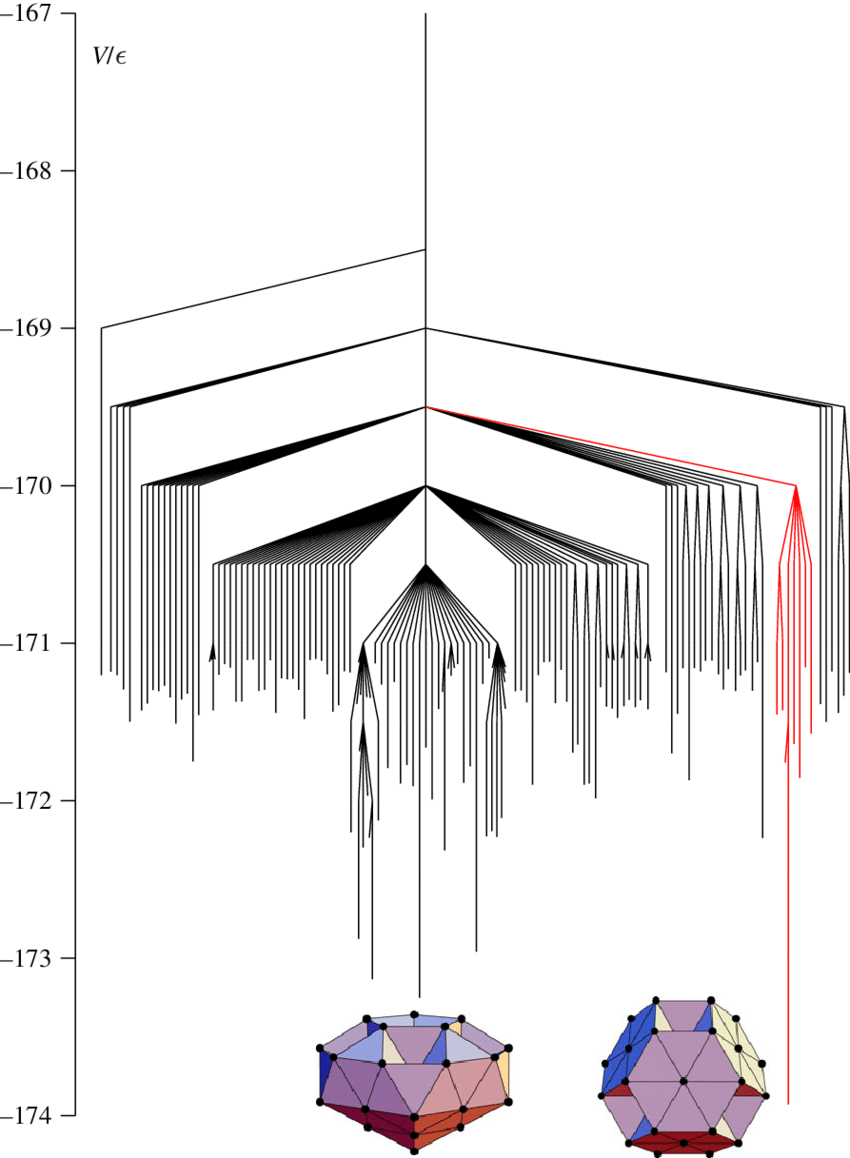

In [30]:
from IPython.display import Image
Image(filename='./Disconnectivity-graph.png', embed=True, height=300,width=400)

Lennard-Jones disconnectivity graph. Each line termination corresponds to a local minimum and its respective height corresponds to a different value of energy according to the the $y$ axis.
Lines break at several levels of energy into groups of minima that are connected by transition states of energy less than that level.

## 1. Preparation for the exercise

This exercise consists in performing one optimization on each of the truncated octahedron and the icosahedron.

Log into your account on `JupyterHub` in a similar manner as described in Exercise 1, and `pull` the newest exercise files from the GitHub repository:

    $ git init
    $ git pull https://github.com/ramador09/Molecular-and-Materials-Modelling-FS2023.git
    $ cd exercise-3_files

Next, we want to prepare the current Jupyter Notebook to run [CP2K](https://www.cp2k.org/), a software package used in physics and chemistry for simulations. It is written in Fortran, in which many modelling procedures are already implemented due to computational efficiency. This proves to be extremely helpful, because it makes it possible for users to avoid programming everything from scratch. Specifics about the algorithms and the system interactions are given with the input file.

### 1.1. (A very cursory and non-comprehensive introduction to) Bash scripting

In order to prepare our terminal to run CP2K, we have to "tell" it to load modules. We do this by interacting with the Terminal, which is done via a series of commands. If you are completely new to the Unix Shell, a nice introduction can be found [here](https://swcarpentry.github.io/shell-novice/). 

1. If we wanted to create a script of (relatively) easily reproducible tasks which are executed in a specific order, Bash scripting presents itself as a good choice. Unfortunately the learning curve is somewhat steep, so we will try to go through those step-by-step here. If you are already familiar with Bash scripting, please skip ahead. 
2. Let's generate our first script. We already know what the command `ls -ltr` does in the command line. But say, instead of typing out and executing `ls -ltr` in the command line, we wanted to create a script for it. How would we proceed?
3. Well first we need to create the file for the script: let's call it `my_first_script.sh`. In order to create a file, execute either
```
$ touch my_first_script.sh
```
or
```
$ vi my_first_script.sh
```
in the command line: the first option simply creates the file, whereas the second will create and open a new file if it doesn't already exist, otherwise it will simply open the existing file. By the way: the `$` is what is called the **prompt**, and indicates that everything which follows should be executed in the command line. *Do not* type the `$` in the command line for this purpose, since the `$` has its own special meaning.
4. The first line of our `my_first_script.sh` file should be the so-called "she-bang", which specifies which interpreter the script will be run in.  Since [Euler uses the Bash shell](https://scicomp.ethz.ch/wiki/Using_the_batch_system) (there are other shells), our she-bang should be:
```
#!/bin/bash
```
5. Now we can put our commands in! Let's keep it simple for now and just do `ls -ltr`.
6. Save the file and try to execute it:
```
$ ./my_first_script.sh
```
You'll probably get an error:
```
>>> bash: my_first_script.sh: Permission denied
```

7. We need to [change the permissions](https://phlow.de/magazin/terminal/chmod-dateirechte-bearbeiten/). Execute

```
$ chmod 700 my_first_script.sh
```
in the command line.

8. Now re-run step 6 and hopefully there's no error. We're ready to start!

### 1.3. Making our `submit.sh` script

This is how our submit script should look like:

```
#!/bin/bash

#SBATCH -N 1 (number of nodes)
#SBATCH -n 9 (number of cores)
#SBATCH --time=4:00:00 
#SBATCH --job-name="lala"
#SBATCH --mem-per-cpu=1024
#SBATCH --output=stdout.txt
#SBATCH --error=stderr.txt

module load gcc/6.3.0 openmpi/4.0.2 cp2k/8.2
mpirun cp2k.psmp -i test1.inp -o test1.out
```

## 2. Geometry optimization
### 2.1. Octahedron

The directory `BFGS-octahedron` contains two files:
* `octahedron.xyz` contains the first geometry that will be optimized during this exercise. It is in XYZ format, i.e.: (i) in the first line the number of atoms is given; (ii) in the second there is a comment; and (iii) in every of the following lines three coordinates of each atom are given. You can have a look at the text file with a double-click on the file, and it will open up in the Launcher.

* `geo-opt.inp` is an input file for running geometry optimizations with CP2K package.

Let's look at the content of these two files more closely:

`$ less octahedron.xyz`.

We can import the libraries and define some functions to view the structures:

In [31]:
import nglview as nv
from ase import Atoms
from ase.visualize import view
from ase.io import read

In [32]:
def view_structure(structure):
    t = nv.ASEStructure(structure)
    w = nv.NGLWidget(t, gui=True)
    w.add_spacefill()
    return w

Here we can visualise what this (**still unoptimized!!**) system looks like in real space:

In [33]:
octa = read('./BFGS-octahedron/octahedron.xyz')

In [34]:
view_structure(octa)

NGLWidget()

Play around with the figure. What symmetries (if any) do we notice?

Let us more closely examine the CP2K input file:

`$ less geo-opt.inp`

### Submitting the script

Once we are finished examining it, we can submit the calculation, making sure that the `submit.sh` file is also in the present directory:

`$ sbatch submit.sh`

When the calculation has concluded running (it should take about 30 seconds... hopefully), we can use the command `ls -ltr` to print out a reverse list of items in the directory according to the time at which it was last updated.

### Viewing the output files

The main output file of this calculation is `geo-opt.out`. It is important to look at it and check if the simulation has converged, crashed because of some problems or if it has just run out of time. In the first lines you can check the input settings and parameters given. After the text `STARTING GEOMETRY OPTIMIZATION`, it is possible to see an analysis of every optimization step and a table of the status of the convergence parameters. Scrolling down the file you will (hopefully) find that the last configuration fulfills all the convergence criteria and that the line:

```
 *****************************************************************************
 ***                   GEOMETRY OPTIMIZATION COMPLETED                     ***
 *****************************************************************************
```

appears. If this is not the case, the job probably ran out of time, and the calculation must be restarted.
Right after this line you can find the energy of the optimized system.
Finally it is important to check the presence of any *warning* in the very end of the document. The text `'The number of warnings for this run is : 0'` means that there were not problems in the simulation and it has not crashed`.

The other output files of the calculation are the following:
* `optimization-BFGS.Hessian` is a binary file that contains the Hessian matrix.
* `optimization-1.restart` (and its backups *`bak-n`*) is an input file that makes the simulation restart from the point where it stopped. It is useful if the simulation stops before it is completed. CP2K automatically creates also backup copies of this file, named `optimization-1.restart.bak-n`.
* `optimization-pos-1.xyz` contains the configurations explored in chronological order during the geometry optimization in XYZ format.

### Viewing the optimized trajectory

We now want to compare the optimized structure with the unoptimized structure. Execute the following three cells in order to visualize the trajectory: (note that it finds the closest minimum) 

In [35]:
def view_trajectory(trajectory):
    t2 = nv.ASETrajectory(trajectory)
    w2 = nv.NGLWidget(t2, gui=True)
    w2.add_spacefill()
    return w2

In [36]:
TRAJ_OCTA = './BFGS-octahedron/octa_opt-pos-1.xyz'
traj_octa = read(TRAJ_OCTA, index=":")

In [37]:
view_trajectory(traj_octa)

NGLWidget(max_frame=185)

Play around with the figure now and watch the animation. How does it compare to the unoptimized variant, in particular with regard to symmetries?

# 3. The Steinhardt order parameters

We now want to generate some plots: execute the first cell block of code to import additional libraries and modules:

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck 
import scipy
from scipy.special import sph_harm
from ase import neighborlist
from pylab import *

The next block simply defines a few parameters for plots which we will generate later:

In [39]:
SMALL_SIZE = 8   #8
MEDIUM_SIZE = 12 #20
BIGGER_SIZE = 12 #12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

The **Steinhardt order parameters** $Q_l$ are rotationally invariant quantities which can be used to fingerprint a system; they are particularly useful with cubic or other systems with a high degree of symmetry. They are defined as:

\begin{equation}
Q_l^2 = \frac{4 \pi}{2l+1} \sum_{m=-l}^l |q_{lm}|^2
\qquad
 \text{with}
 \qquad
 q_{lm} = \frac{1}{N_{bonds}} \sum_{N_n} Y_{lm} (\theta_{ij}, \phi_{ij}),
\end{equation}

where the $Y_{lm}(\theta_{ij}, \phi_{ij})$ are the spherical harmonics. These parameters hold the information of the local structure and, depending on the choice of $l$, are sensitive to different symmetries. $Q_4$ and $Q_6$ will, for instance, discriminate between cubic and hexagonal structures.

We first define a general python function for the calculation of $Q_l$ , and then compute $Q_6$ by simply calling the function. Execute the following block of code, which defines the order parameters `QL`:

In [40]:
def QL(l, shape): #l is 4 or 6, shape is trajectory file
    
    rcut = 3.405*1.391/2 #in Angstrom
    
    #update the cutoff for each frame
    for frame in shape: 
        array_rcut         = np.ones(len(frame))*rcut
        new_neighbour_list = neighborlist.NeighborList(array_rcut,skin=0, self_interaction=False, bothways=False)
        new_neighbour_list.update(frame)
    

    #compute Ql for each frame
    Ql = np.empty(len(shape))
    i  = 0
    
    for frame in shape:
        nbonds = 0
        qlm    = np.zeros(2*l+1) 
        
        for atom in frame:
            nlist = new_neighbour_list.get_neighbors(atom.index)[0]

                
            for theneig in nlist:   #cycle over the neighbours
                #get angles and distances
                nbonds   = nbonds+1
                rij      = frame[theneig].position - atom.position
                dist     = np.linalg.norm(rij)
                phi_ij   = np.arccos(rij[2]/dist)
                theta_ij = np.arctan2(rij[1],rij[0])
                if theta_ij < 0:
                    theta_ij += 2*np.pi
                
                #move in spherical coordinates space
                    # In a like-oriented coordinate system at j,
                    #the spherical coordinates of atom i are:
                if theta_ij  <= np.pi:
                    theta_ji  = theta_ij + np.pi
                elif theta_ij > np.pi:
                    theta_ji  = theta_ij - np.pi
                if np.absolute(theta_ji-2*np.pi)<0.0001:
                    theta_ji=0.0
                phi_ji = np.pi-phi_ij
                
                #compute spherical harmonics and perform qml summation 
                qlm = qlm + np.array([ sph_harm(m,l,theta_ij,phi_ij) for m in range(-l,l+1) ])
                
        qlm   =  np.real(qlm*np.conj(qlm)/(nbonds*nbonds))
        
        #prefactor and second summation
        Ql[i] =  np.sqrt(np.pi *4 /(2*l+1)*np.sum(qlm))
        i    += 1
    return Ql;

This function `QL(l, shape)` defines how we will calculate the Steinhardt order parameters and takes the order $l$, and the trajectory, here given the keyword parameter `shape`, as its arguments. We then execute the cod` block defining the **asphericity**:

In [41]:
def get_asph(shape):
    I = np.empty([0,3])
    for frame in shape:
        I = np.append(I,[frame.get_moments_of_inertia()],axis=0)
    I = I.transpose()
    return ((I[0]- I[1])**2 + (I[0]- I[2])**2 + (I[2]- I[1])**2 )/ (I[0]**2 + I[1]**2 + I[2]**2)

In order to proceed, we need to extract the total energy as a function of the optimization step. The total energy of each configuration is given in the main output file `optimization-pos-1.xyz`. For instance, the ninth optimization step in the `optimization-pos-1.xyz` file looks like:

```
      38
 i =        9, E =        -0.0292336614 
```

where the energy is in units of Ha. The following script will extract the values for the energy and write them to a file `energy.dat` directly in the Jupyter notebook:

In [42]:
! grep "E" ./BFGS-octahedron/octa_opt-pos-1.xyz | awk '{print $3,$6}' | awk -F "," '{print $1,$2}' > ./energy.dat

Generate a plot of the energy vs. optimization step by running the code block:

Text(0.5, 0, 'Optimization step ')

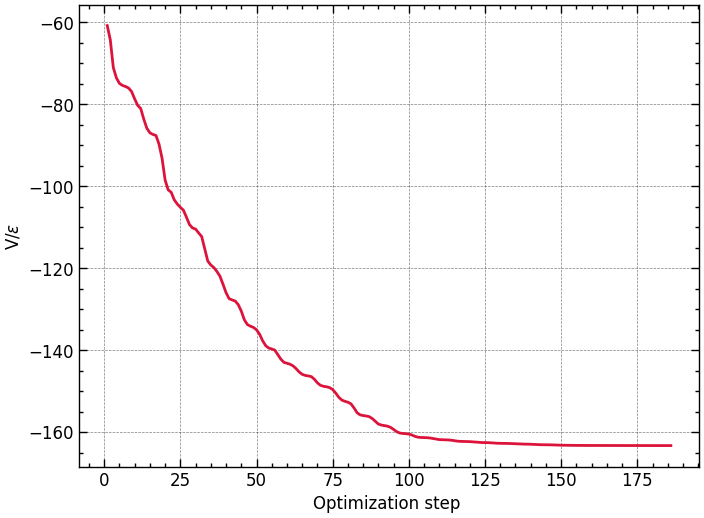

In [43]:
energy     = np.loadtxt('energy.dat')
energy     = np.transpose(energy)
#epsilon/kB =119.8 K      KB = 8.616733e-5 eV/K 
epsilon    = 119.8*8.616733e-5 #K * eV/K = eV
energy[1] *= 27.1442/epsilon #eV / epsilon(eV)
min_e      = np.min(energy[1])
#energy[1] -= min_e
min_e

fig = plt.plot(energy[0],energy[1],color='crimson', lw=2)
#fig = plt.plot(energy[0],get_asph(traj_octa),color='crimson', lw=2)
#get the axis just defined
ax  = plt.gca()
ax.set_ylabel("V/$\epsilon$")
ax.set_xlabel("Optimization step ")

#### Assignment 1: Plot analysis
Comment on a few features of this plot: peaks, range, form, etc. What do we see for increasing optimization step?

The total energy decreases with increasing optimization step, as the particles are rearranged by the BFGS algorithm into configurations with lower total energy. The peak energy (-60) lies at the start of the optimisation, and with each step, it monotonically decreases. The decrease in energy with each step also becomes smaller towards the end of the optimisation process, with the algorithmn converges at around Step 100. Beyond step 100, the energy of the configuration remains stable at the  value of -163, meaning that the minima has been found, with subsequent perturbations in configurations not lowering the energy any further. 

#### End Assignment 1

Finally we plot the asphericity and $Q_6$ with respect to optimization step:

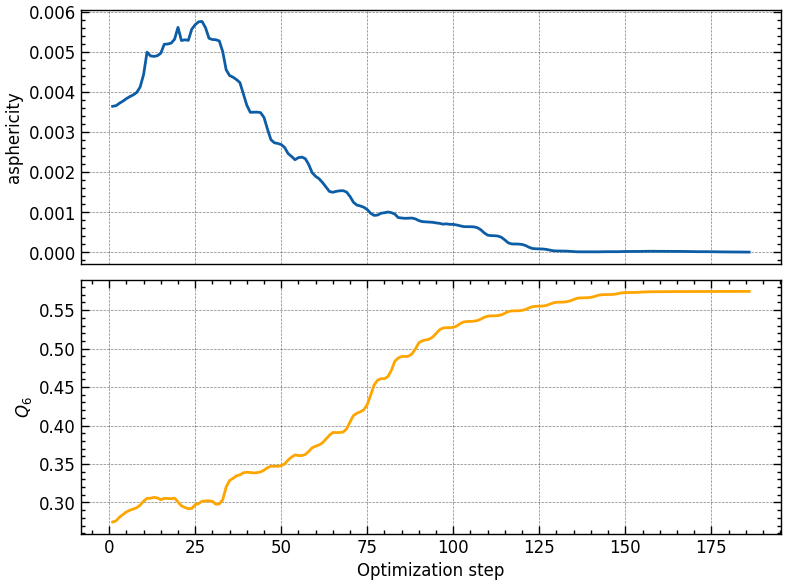

In [44]:
fig, ax = plt.subplots(2,1,sharex='col',squeeze ='False')
Q6=QL(6, shape=traj_octa)

#FIRST PLOT
ax[0].plot(energy[0],get_asph(traj_octa), lw=2)
ax[0].xaxis.set_ticks_position('none')
ax[0].set_ylabel("asphericity")

#SECOND PLOT
ax[1].plot(energy[0],Q6, color = 'orange',lw=2)
ax[1].set_xlabel("Optimization step")
ax[1].set_ylabel("$Q_6$")


plt.subplots_adjust( hspace=1)
plt.tight_layout()
#plt.savefig("NEB_order_parameters.png",  dpi=300,transparent=True)
plt.show()

#### Assignment 2: Construction of plots for the mean and variance of distance

Using the definition of $Q_l$ as a template, generate plots of the mean and variance of $r$ as a function of optimization step. The comments in the code block should help you delete the unnecessary/superfluous lines of code. Nonetheless, if you need/want some hints:
1. As we will still have the optimization step on the horizontal axis, the cutoff for each frame will still need to be updated; thus, this code section should stay the same.
2. Just as we did in defining the $Q_l$, we need to first initialise an array whose size is equal to that of the object whose means (or variances) we would like to compute.
3. Consult the [ASE documentation for building neighbor-lists](https://databases.fysik.dtu.dk/ase/ase/neighborlist.html) (or just ask either me or in the Moodle forum) if you get stuck

Text(0, 0.5, 'Variance of distance')

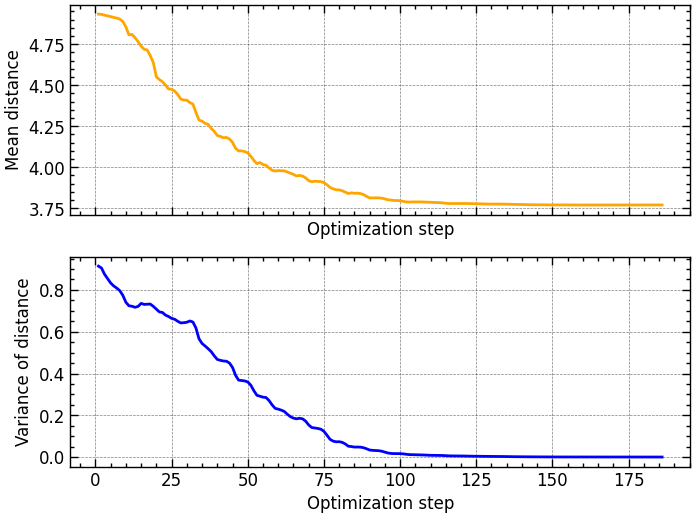

In [45]:
##--Your code here

def meandistance(shape): 
    
    rcut = 3.405*1.391/2 #in Angstrom
    
    #update the cutoff for each frame
    for frame in shape: 
        array_rcut         = np.ones(len(frame))*rcut
        new_neighbour_list = neighborlist.NeighborList(array_rcut,skin=0, self_interaction=False, bothways=False)
        new_neighbour_list.update(frame)
    
    #compute meandistance for each frame
    meandistance = np.empty(len(shape))
    i  = 0
    
    for frame in shape:
        nbonds = 0
        totaldist = 0
        
        for atom in frame:
            nlist = new_neighbour_list.get_neighbors(atom.index)[0]

   
            for theneig in nlist:   #cycle over the neighbours             
                rij      = frame[theneig].position - atom.position
                dist     = np.linalg.norm(rij)
                nbonds   = nbonds+1
                totaldist = totaldist + dist #count the total number of bonds and total distances       
        
        mean = totaldist/nbonds       
        meandistance[i] = mean
        i    += 1
   
    return meandistance;

def meansquaredistance(shape): 
    
    rcut = 3.405*1.391/2 #in Angstrom
    
    #update the cutoff for each frame
    for frame in shape: 
        array_rcut         = np.ones(len(frame))*rcut
        new_neighbour_list = neighborlist.NeighborList(array_rcut,skin=0, self_interaction=False, bothways=False)
        new_neighbour_list.update(frame)
    
    #compute meansquaredistance for each frame
    meansquaredistance = np.empty(len(shape))
    i  = 0
    
    for frame in shape:
        nbonds = 0
        totalsquaredist = 0
        
        for atom in frame:
            nlist = new_neighbour_list.get_neighbors(atom.index)[0]

   
            for theneig in nlist:   #cycle over the neighbours             
                rij      = frame[theneig].position - atom.position
                dist     = np.linalg.norm(rij)
                nbonds   = nbonds+1
                totalsquaredist = totalsquaredist + dist*dist #count the total number of bonds and total distances       
        
        meansquare = totalsquaredist/nbonds
        meansquaredistance[i] = meansquare
        i    += 1
   
    return meansquaredistance;



fig, ax = plt.subplots(2,1,sharex='col',squeeze ='False')

meandistance6=meandistance(shape=traj_octa)
meansquaredistance6 = meansquaredistance(shape=traj_octa)
variance6 = meansquaredistance6 - (meandistance6*meandistance6) # Variance = <d^2> - <d>^2



#MEAN PLOT
ax[0].plot(energy[0],meandistance6, color = 'orange',lw=2)
ax[0].set_xlabel("Optimization step")
ax[0].set_ylabel("Mean distance")


#VARIANCE PLOT
ax[1].plot(energy[0],variance6, color = 'blue',lw=2)
ax[1].set_xlabel("Optimization step")
ax[1].set_ylabel("Variance of distance")



As expected, the mean and variance of distance between the atoms decreases with increasing optimisation step until convergence for the octahedron configuration. This also directly corresponds to the animated trajectory. The variance also converged to a value very close to zero, suggesting that the bonds are highly uniform in length, and there is a high degree of symmetry in different directions. 

#### End Assignment 2

### 2.3 Icosahedron

#### Assignment 3: Optimization of the icosahedron

Repeat the submission procedure to submit the calculation for the icosahedron. After the calculation finishes, view the structure and trajectory, making all changes as necessary to the respective filepaths, names of variables, etc.

In [46]:
#--Your code here

#the code used for submitting the calculation is in the folder 


icos = read('./BFGS-icosahedron/icosahedron.xyz')
view_structure(icos) 


TRAJ_ICOS = './BFGS-icosahedron/icos_opt-pos-1.xyz'
traj_icos = read(TRAJ_ICOS, index=":")
view_trajectory(traj_icos)

NGLWidget(max_frame=59)

Icosahedral symmetry was indeed observed for the final step, with five atoms surrounding the central atom when viewed from the top. The overall appearance is also relatively flat compared to the octrahedral structure. An increase in distance can be observed in the third step. 

#### End Assignment 3

#### Assignment 4: Asphericity and order parameters of the icosahedron
Repeat Section 2.2 for the icosahedron (you should only need to change a few parameters such as filepaths and names of variables and/or files) to obtain the analogues to Figs. 6 and 7 in the walkthrough file. Comment on their appearance and compare the plots of the octahedron with those of the icosahedron.

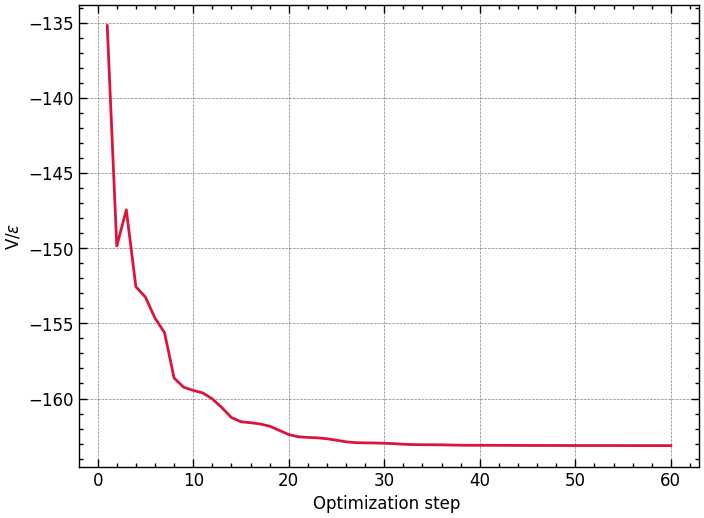

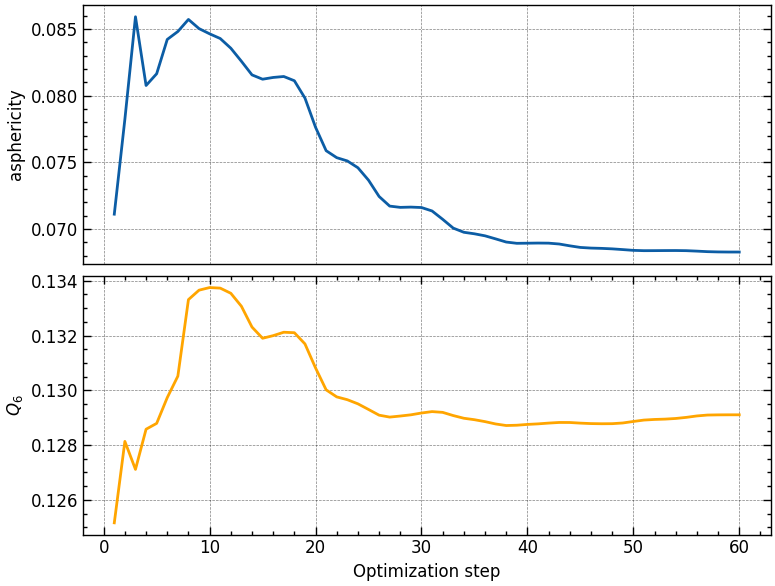

In [47]:
#--Your code here
! grep "E" ./BFGS-icosahedron/icos_opt-pos-1.xyz | awk '{print $3,$6}' | awk -F "," '{print $1,$2}' > ./energy2.dat

energy2     = np.loadtxt('energy2.dat')
energy2     = np.transpose(energy2)
#epsilon/kB =119.8 K      KB = 8.616733e-5 eV/K 
epsilon    = 119.8*8.616733e-5 #K * eV/K = eV
energy2[1] *= 27.1442/epsilon #eV / epsilon(eV)
min_e      = np.min(energy[1])
#energy[1] -= min_e
min_e

fig = plt.plot(energy2[0],energy2[1],color='crimson', lw=2) #plot of energy against optimisation step
#fig = plt.plot(energy[0],get_asph(traj_octa),color='crimson', lw=2)
#get the axis just defined
ax  = plt.gca()
ax.set_ylabel("V/$\epsilon$")
ax.set_xlabel("Optimization step ")


fig, ax = plt.subplots(2,1,sharex='col',squeeze ='False')
Q6=QL(6, shape=traj_icos)

#Plot of asphericity
ax[0].plot(energy2[0],get_asph(traj_icos), lw=2)
ax[0].xaxis.set_ticks_position('none')
ax[0].set_ylabel("asphericity")

#Plot of Q6
ax[1].plot(energy2[0],Q6, color = 'orange',lw=2)
ax[1].set_xlabel("Optimization step")
ax[1].set_ylabel("$Q_6$")

plt.subplots_adjust( hspace=1)
plt.tight_layout()
#plt.savefig("NEB_order_parameters.png",  dpi=300,transparent=True)
plt.show()



Similar to the energy plots for the octahedron, the total energy also decreases with increasing optimisation step, except now it converges in smaller number of steps (30 steps) However, one notable difference is the spike at around step 3, which is also visible in the sphericity and the Q6 plots. From observing the trajectory and plotting out the mean distance, the spike seems to be caused by repulsion between atoms after they have approached too close to each other.

Since repulsive forces are much more sensitive to distance, the atoms are pushed further apart back into the attractive regime, further away from the minima than the previous step, thus leading to a rise in energy. Afterwards, by approaching each other differently and rearranging into an icosahedron, the energy continues to decrease as normal.

In addition, the Q6 for the icosahedron also converges to a different, smaller value of around 0.130 compared to the that of the octahedron (0.58) as Q6 is sensitive to the symmetry of the structure. Q6 therefore serves as a way to distinguish between the octahedral and icosahedral symmetries. 

#### Additional Investigation: Difference between using Q4 an Q6 for octahedron and icosahedron

Text(0, 0.5, '$Q_4$ (icosahedron)')

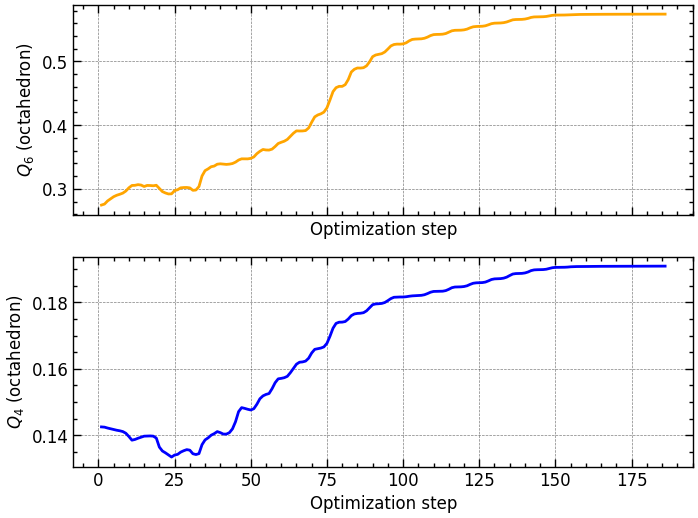

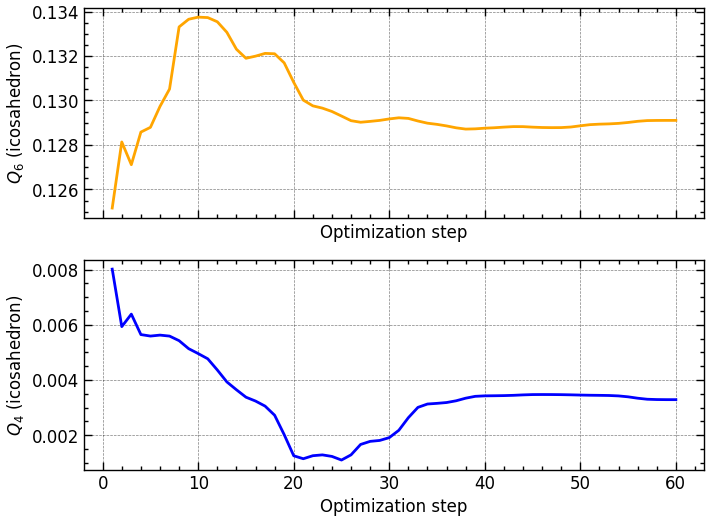

In [48]:

fig, ax = plt.subplots(2,1,sharex='col',squeeze ='False')
Q6=QL(6, shape=traj_octa)
Q4=QL(4, shape=traj_octa)
ax[0].plot(energy[0],Q6, color = 'orange',lw=2)
ax[0].set_xlabel("Optimization step")
ax[0].set_ylabel("$Q_6$ (octahedron)")

ax[1].plot(energy[0],Q4, color = 'blue',lw=2)
ax[1].set_xlabel("Optimization step")
ax[1].set_ylabel("$Q_4$ (octahedron)")


fig, ax = plt.subplots(2,1,sharex='col',squeeze ='False')
Q6=QL(6, shape=traj_icos)
Q4=QL(4, shape=traj_icos)
ax[0].plot(energy2[0],Q6, color = 'orange',lw=2)
ax[0].set_xlabel("Optimization step")
ax[0].set_ylabel("$Q_6$ (icosahedron)")
ax[1].plot(energy2[0],Q4, color = 'blue',lw=2)
ax[1].set_xlabel("Optimization step")
ax[1].set_ylabel("$Q_4$ (icosahedron)")

From the plots of Q6 and Q4, it can be seen that Q6 is a better indicator of symmetry than Q4. Firstly  it provides values of higher magnitude after convergence for both the octahedron and icosahedron symmetries, making them much more distinguishable from other disordered configurations. This is especially true in the case of icosahedral symmetry, where the converged Q4 is only a tiny fraction (0.0035) of the converged Q6 value (0.129).  Secondly, it also better for distinguishing between the two symmetries, as the absolute difference in magnitude of Q6 between octahedral and icosahedral symmetries (0.58-0.129 = 0.451) is larger than that of Q4 (around 0.19).  

#### End Assignment 4

#### Assignment 5
Repeat Assignment 2 for the icosahedron: generate plots for the mean and variance of the distance.

Text(0, 0.5, 'Variance of distance')

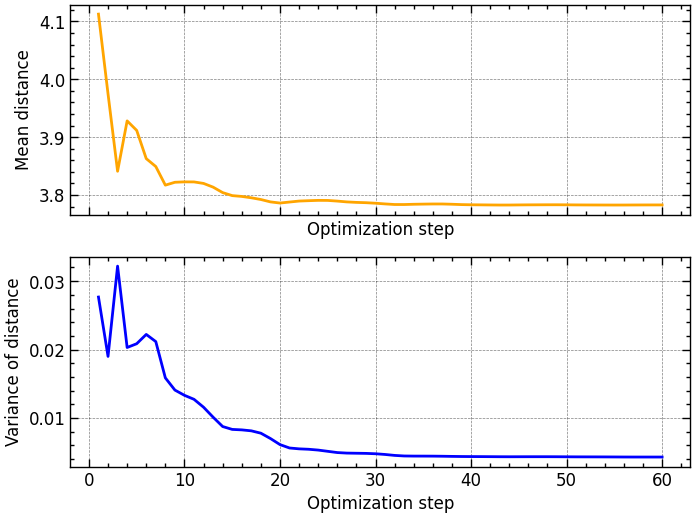

In [50]:
##--Your code here


def meandistance(shape): 
    
    rcut = 3.405*1.391/2 #in Angstrom
    
    #update the cutoff for each frame
    for frame in shape: 
        array_rcut         = np.ones(len(frame))*rcut
        new_neighbour_list = neighborlist.NeighborList(array_rcut,skin=0, self_interaction=False, bothways=False)
        new_neighbour_list.update(frame)
    
    #compute meandistance for each frame
    meandistance = np.empty(len(shape))
    i  = 0
    
    for frame in shape:
        nbonds = 0
        totaldist = 0
        
        for atom in frame:
            nlist = new_neighbour_list.get_neighbors(atom.index)[0]

   
            for theneig in nlist:   #cycle over the neighbours             
                rij      = frame[theneig].position - atom.position
                dist     = np.linalg.norm(rij)
                nbonds   = nbonds+1
                totaldist = totaldist + dist #count the total number of bonds and total distances       
        
        mean = totaldist/nbonds       
        meandistance[i] = mean
        i    += 1
   
    return meandistance;

def meansquaredistance(shape): 
    
    rcut = 3.405*1.391/2 #in Angstrom
    
    #update the cutoff for each frame
    for frame in shape: 
        array_rcut         = np.ones(len(frame))*rcut
        new_neighbour_list = neighborlist.NeighborList(array_rcut,skin=0, self_interaction=False, bothways=False)
        new_neighbour_list.update(frame)
    
    #compute meansquaredistance for each frame
    meansquaredistance = np.empty(len(shape))
    i  = 0
    
    for frame in shape:
        nbonds = 0
        totalsquaredist = 0
        
        for atom in frame:
            nlist = new_neighbour_list.get_neighbors(atom.index)[0]

   
            for theneig in nlist:   #cycle over the neighbours             
                rij      = frame[theneig].position - atom.position
                dist     = np.linalg.norm(rij)
                nbonds   = nbonds+1
                totalsquaredist = totalsquaredist + dist*dist #count the total number of bonds and total distances       
        
        meansquare = totalsquaredist/nbonds
        meansquaredistance[i] = meansquare
        i    += 1
   
    return meansquaredistance;


fig, ax = plt.subplots(2,1,sharex='col',squeeze ='False')

meandistance6=meandistance(shape=traj_icos)
meansquaredistance6 = meansquaredistance(shape=traj_icos)
variance6 = meansquaredistance6 - (meandistance6*meandistance6) # Variance = <d^2> - <d>^2



#MEAN PLOT
ax[0].plot(energy2[0],meandistance6, color = 'orange',lw=2)
ax[0].set_xlabel("Optimization step")
ax[0].set_ylabel("Mean distance")


#VARIANCE PLOT
ax[1].plot(energy2[0],variance6, color = 'blue',lw=2)
ax[1].set_xlabel("Optimization step")
ax[1].set_ylabel("Variance of distance")

Similar to the plots for the octahedron, the mean and variance of the distance between atoms decreases with increasing steps, with a jump in both at step 2 as previously mentioned. Another thing to notice is that the variance converges to a higher value than that of the octahedron, meaning that the distance between atoms are less uniform. This is related to the "flatness" observed in the 3D icosahedral structure plot. 

#### End Assignment 5